# Neural Style Transfer

**Resources:**
* [Original paper - A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
* [Demystifying Neural Style Transfer](https://arxiv.org/abs/1701.01036)
* [Official PyTorch Tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Blog by Amar](https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa)

## Paper overview
### Model

Here is how each image is "ran-forward" with vgg19 and what outputs are saved/used to optimize the **content image**

![model](https://user-images.githubusercontent.com/16206648/139554170-1c63cd04-c83f-4ea8-bb12-da05b87d5c9a.jpg)


### Loss

#### Total Loss

$$
\mathcal{L}_{total}(\vec{p}, \vec{a}, \vec{x}) = \alpha\mathcal{L}_{content}(\vec{p}, \vec{x}) + \beta\mathcal{L}_{style}(\vec{a}, \vec{x}) \tag{1}
$$
$ \vec{p} $ - content image  
$ \vec{a} $ - style image   
$ \vec{x} $ - generated image   
$ \alpha $ - content coefficient   
$ \beta $ - style cooefficient 

> Generated image $\vec{x}$ can be either initialized as content image or white noise (random values).

#### Content Loss

$$
\mathcal{L}_{content}(\vec{p}, \vec{x}) = \dfrac{1}{2} \sum_{i,j}(F_{i,j}^{l} - P_{i,j}^{l})^2 \tag{2}
$$

Content loss is a squared error between: 
  
$ F_{i,j}^{l} $ - Output of conv layer **$l$** for input (generated) image  
$ P_{i,j}^{l} $ - Output of conv layer **$l$** for content image  

> $ i, j $ represent **i-th** position of the filter at position **j** which implementation-wise doesn't change anything as we take whole outputs of conv layers

There's a small difference in notation when it comes to implementation. In paper, $F^{l}$ is defined as $F^{l} \in \mathbb{R}^{N_l x M_l}$, which means it's a matrix with shape ($N_l$ - number of feature maps, $M_l$ - $width * height$ of feature maps). In contrast, here we have $F^{l} \in \mathbb{R}^{N_l x H_l x W_l}$ which is just a reshaped version of the matrix in the paper.

#### Style Loss

Instead of taking raw conv layer outputs as in content loss, style loss firstly computes Gram matrix. They mentioned that Gram matrix computes feature correlations between feature maps? (will have to look more into what that exactly means).
$$
G_{i,j}^l = \sum_{k}(F_{i,k}^lF_{j,k}^l) \tag{3}
$$
where:

$F_{i,k}^l$ is output of conv layer **$l$**, defined as $F^{l} \in \mathbb{R}^{N_l x M_l}$, where $(N_l = channels, M_l = height * width)$  
$F_{j,k}^l$ is transposed version of previously mentioned matrix

This essentially means $G$ is computed as $F * F^T$ and $G \in \mathbb{R}^{NxN}$

> Because $G$ is of shape $NxN$, it means that the dimensions of Gram matrix vary between conv layers with different number of feature maps. In official PyTorch tutorial this is resolved by normalazing each gram matrix by dividing it with its number of elements. I haven't seen this in paper but I'll test both **with** and **without** normalization.

With *Gram matrix* defined, they computed the **loss per layer** as mean-squared error:
$$
E_l = \dfrac{1}{4N_l^2M_l^2}\sum_{i,j}(G_{i,j}^l-A_{i,j}^l)^2\tag{4}
$$
> How the hell is this mean?

## Experiments

Here I examined several experiments:
1. Gram matrix values (Normalized vs Not-normalized)
2. Number of iterations (Differences in quality)
3. Impact of style losses in different layers
4. Adam vs LBFG-S optimizer

In [2]:
import pandas as pd
import numpy as np
import requests

def load_losses(url: str) -> pd.DataFrame:
    """Loads losses in JSON format from URL
    """
    response = requests.get(url)
    response.raise_for_status()
    losses = response.json()['losses']
    return pd.DataFrame(losses)

### Gram matrix values (Normalized vs Not-normalized)

Images without normalization tend to be very blurry.

![Normalized_gram_matrix](https://github.com/bvezilic/Neural-style-transfer/blob/gram-matrix-norm-True/results/style_transfer_results.jpg?raw=true)

![Not_normalized_gram_matrix](https://github.com/bvezilic/Neural-style-transfer/blob/gram-matrix-norm-False/results/style_transfer_results.jpg?raw=true)

### Number of iterations

Number of iteration isn't exactly corret. LBFGS optimizer does 20 updates per iterations. So the number of steps is
* 5 iterations = 100 steps
* 10 terations = 200 steps
* 20 iterations = 400 steps

There isn't a *huge* difference in generated images as the **loss** seems to drop quite fast. More on losses in later experiments.

![5_iterations_run](https://github.com/bvezilic/Neural-style-transfer/blob/iterations=5/results/style_transfer_results.jpg?raw=true)

![10_iterations_run](https://github.com/bvezilic/Neural-style-transfer/blob/iterations=10/results/style_transfer_results.jpg?raw=true)

![20_iterations_run](https://github.com/bvezilic/Neural-style-transfer/blob/iterations=20/results/style_transfer_results.jpg?raw=true)

### Impact of losses in different layers

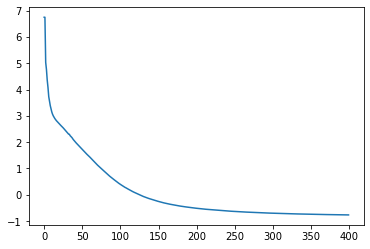

In [3]:
df = load_losses('https://github.com/bvezilic/Neural-style-transfer/blob/iterations%3D20/results/losses_Pablo_Picasso_Figure_dans_un_Fauteuil.jpg.json?raw=true')
ax = df.loc[:, 'total_loss'].apply(np.log).plot.line()

Adam vs LBFGS